In [22]:
# 1.1 Install / import required free libraries
# If running in a fresh environment, uncomment installs below; else skip.
# !pip install pandas numpy scikit-learn matplotlib seaborn nltk
# Optional: spaCy for more advanced NLP (free models)
# !pip install spacy
# !python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Download NLTK resources if not already installed
#nltk.download('punkt')
#nltk.download('stopwords')

In [23]:
# 2.1 Create synthetic data
np.random.seed(42)

n_rows = 5000

dates = pd.date_range(start='2023-01-01', periods=n_rows, freq='D')
regions = ['North', 'South', 'East', 'West', 'Central']
store_types = ['Supermarket', 'Convenience', 'Online']
age_groups = ['18-25', '26-35', '36-50', '50+']
income_levels = ['Low', 'Middle', 'High']

# Random draws
data = pd.DataFrame({
    'date': np.random.choice(dates, n_rows),
    'region': np.random.choice(regions, n_rows),
    'store_type': np.random.choice(store_types, n_rows),
    'age_group': np.random.choice(age_groups, n_rows),
    'income_level': np.random.choice(income_levels, n_rows),
    # price per unit in GBP, around £1.5-3.0
    'price': np.round(np.random.uniform(1.5, 3.0, n_rows), 2),
    # promotion flag
    'promo': np.random.binomial(1, 0.2, n_rows),
    # units sold (base) with regional differences
    'units_sold': np.random.poisson(50, n_rows)
})

# Add seasonality and promo uplift
data['month'] = data['date'].dt.month
# season factor: higher in summer months (6-8)
data['season_factor'] = data['month'].apply(lambda m: 1.2 if m in [6,7,8] else 1.0)
data['units_sold'] = (data['units_sold'] * data['season_factor']).astype(int)

# promo uplift + random noise
data['units_sold'] += data['promo'] * np.random.randint(5, 20, n_rows)
data['units_sold'] = data['units_sold'].clip(lower=0)

# revenue
data['revenue'] = data['price'] * data['units_sold']

# assume cost per unit: 60-75% of price
data['cost_per_unit'] = np.round(data['price'] * np.random.uniform(0.6, 0.75, n_rows), 2)
data['cost_total'] = data['cost_per_unit'] * data['units_sold']

# profit
data['profit'] = data['revenue'] - data['cost_total']
data['profit_margin'] = np.where(data['revenue'] > 0,
                                 data['profit'] / data['revenue'],
                                 0)

# quick look
data.head()

,date,region,store_type,age_group,income_level,price,promo,units_sold,month,season_factor,revenue,cost_per_unit,cost_total,profit,profit_margin
0,2025-05-10,North,Convenience,36-50,Low,1.64,0,49,5,1.0,80.36,1.13,55.37,24.99,0.310976
1,2033-04-30,North,Supermarket,50+,High,2.37,0,41,4,1.0,97.17,1.76,72.16,25.01,0.257384
2,2031-06-20,East,Supermarket,36-50,High,2.42,0,57,6,1.2,137.94,1.65,94.05,43.89,0.318182
3,2024-04-11,West,Online,36-50,High,2.59,0,48,4,1.0,124.32,1.66,79.68,44.64,0.359073
4,2035-02-13,North,Convenience,26-35,Middle,2.64,1,49,2,1.0,129.36,1.65,80.85,48.51,0.375000


                              date region   store_type age_group income_level  \
count                         5000   5000         5000      5000         5000   
unique                         NaN      5            3         4            3   
top                            NaN  South  Convenience     26-35       Middle   
freq                           NaN   1053         1696      1272         1693   
mean    2029-12-01 11:22:33.600000    NaN          NaN       NaN          NaN   
min            2023-01-02 00:00:00    NaN          NaN       NaN          NaN   
25%            2026-07-09 18:00:00    NaN          NaN       NaN          NaN   
50%            2029-12-27 12:00:00    NaN          NaN       NaN          NaN   
75%            2033-03-23 06:00:00    NaN          NaN       NaN          NaN   
max            2036-09-07 00:00:00    NaN          NaN       NaN          NaN   
std                            NaN    NaN          NaN       NaN          NaN   

              price        

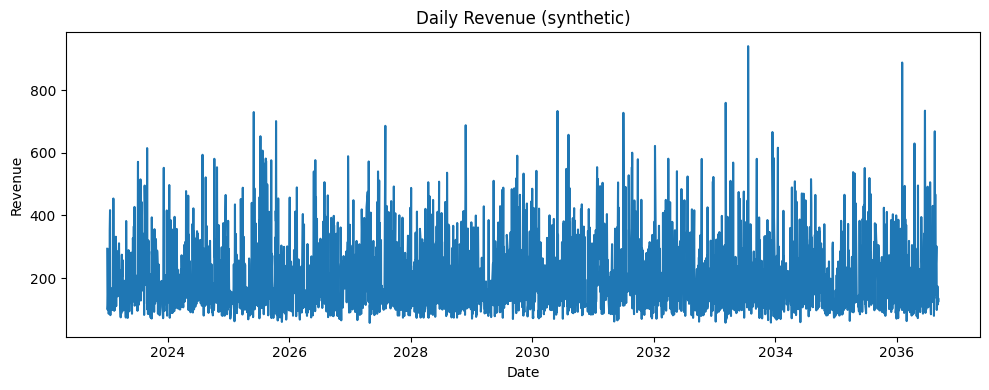

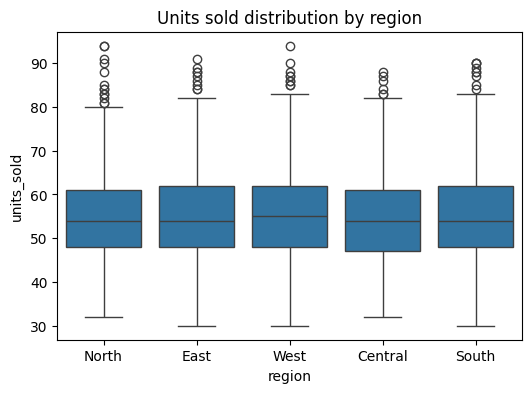

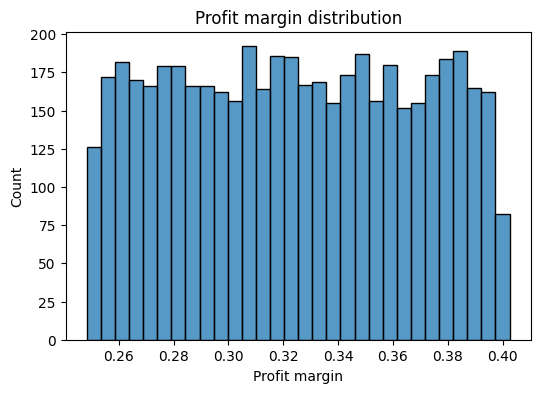

In [24]:
# 3.1 Summary stats
print(data.describe(include='all'))

# 3.2 Sales over time
daily = data.groupby('date')['revenue'].sum().reset_index()
plt.figure(figsize=(10,4))
plt.plot(daily['date'], daily['revenue'])
plt.title('Daily Revenue (synthetic)')
plt.xlabel('Date'); plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

# 3.3 Units sold by region
plt.figure(figsize=(6,4))
sns.boxplot(x='region', y='units_sold', data=data)
plt.title('Units sold distribution by region')
plt.show()

# 3.4 Profit margin distribution
plt.figure(figsize=(6,4))
sns.histplot(data['profit_margin'], bins=30)
plt.title('Profit margin distribution')
plt.xlabel('Profit margin')
plt.show()

In [25]:
# 4.1 Simulate simple text mentions aligned to region or promo
texts = [
    "Great taste and value",
    "Too sweet",
    "Love the new flavor",
    "Prefer sugar-free option",
    "Good deal when on promo",
    "Not buying this week"
]

data['text_review'] = np.random.choice(texts, n_rows)

In [26]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_and_stem(text):
    if not isinstance(text, str):
        return ""
    
    # Simple regex tokenizer (no punkt needed)
    tokens = re.findall(r"[a-zA-Z]+", text.lower())
    
    cleaned = [
        stemmer.stem(t)
        for t in tokens
        if t not in stop_words
    ]
    
    return " ".join(cleaned)

data['text_clean'] = data['text_review'].apply(clean_and_stem)

data[['text_review', 'text_clean']].head()

,text_review,text_clean
0,Great taste and value,great tast valu
1,Prefer sugar-free option,prefer sugar free option
2,Not buying this week,buy week
3,Too sweet,sweet
4,Great taste and value,great tast valu


In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Example with simple count vectors
vectorizer = CountVectorizer(max_features=20)
text_features = vectorizer.fit_transform(data['text_clean'])
text_df = pd.DataFrame(text_features.toarray(),
                       columns=[f"text_{w}" for w in vectorizer.get_feature_names_out()])

# Combine with main data
model_df = pd.concat([data.reset_index(drop=True), text_df], axis=1)

In [28]:
# 5.1 One-hot encode categorical variables
categorical_cols = ['region', 'store_type', 'age_group', 'income_level']
model_df_enc = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

# 5.2 Choose features for sales prediction
feature_cols = [
    'price', 'promo', 'month'
] + [col for col in model_df_enc.columns if col.startswith('region_') or
     col.startswith('store_type_') or col.startswith('age_group_') or
     col.startswith('income_level_') or col.startswith('text_')]
# Drop columns not needed
X = model_df_enc[feature_cols]
y = model_df_enc['units_sold']  # or revenue, depending on objective

# 5.3 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Split data (if not already done)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [30]:
print(X_train.dtypes)

price                     float64
promo                       int64
month                       int32
text_review                object
text_clean                 object
text_buy                    int64
text_deal                   int64
text_flavor                 int64
text_free                   int64
text_good                   int64
text_great                  int64
text_love                   int64
text_new                    int64
text_option                 int64
text_prefer                 int64
text_promo                  int64
text_sugar                  int64
text_sweet                  int64
text_tast                   int64
text_valu                   int64
text_week                   int64
region_East                  bool
region_North                 bool
region_South                 bool
region_West                  bool
store_type_Online            bool
store_type_Supermarket       bool
age_group_26-35              bool
age_group_36-50              bool
age_group_50+ 

In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Convert categorical variables to numeric (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# If any pure text columns still exist, remove them
X = X.select_dtypes(include=['number'])

# Fit model
lr = LinearRegression()
lr.fit(X, y)

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_
})

# Sort by absolute coefficient value
coef_df = coef_df.reindex(
    coef_df['coefficient'].abs().sort_values(ascending=False).index
)

# Show top 10
coef_df.head(10)

,feature,coefficient
1,promo,11.660708
2,month,0.170829
0,price,0.141137
6,text_free,0.116323
11,text_option,0.116323
14,text_sugar,0.116323
12,text_prefer,0.116323
7,text_good,-0.062051
13,text_promo,-0.062051
4,text_deal,-0.062051


In [32]:
# -----------------------------
# 8. Feature Importance (FIXED)
# -----------------------------

# Get transformed feature names directly
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()

# Get importances
importances = rf_model.named_steps['regressor'].feature_importances_

imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Important Features:")
print(imp_df.head(10))


Top 10 Important Features:
            feature  importance
0        num__price    0.355210
2        num__month    0.288029
1        num__promo    0.221163
15  num__text_sweet    0.020184
18   num__text_week    0.010737
3     num__text_buy    0.010182
16   num__text_tast    0.008025
17   num__text_valu    0.008009
8   num__text_great    0.008008
4    num__text_deal    0.007994


In [21]:
imp_margin = pd.DataFrame({
    'feature': X_margin.columns,
    'importance': rf_margin.feature_importances_
}).sort_values(by='importance', ascending=False)

imp_margin.head(10)

,feature,importance
0,price,0.510604
2,month,0.225891
1,promo,0.055868
15,text_sweet,0.030363
3,text_buy,0.016383
18,text_week,0.016050
9,text_love,0.012818
10,text_new,0.012794
5,text_flavor,0.012704
17,text_valu,0.012120
